0.46445416666666667


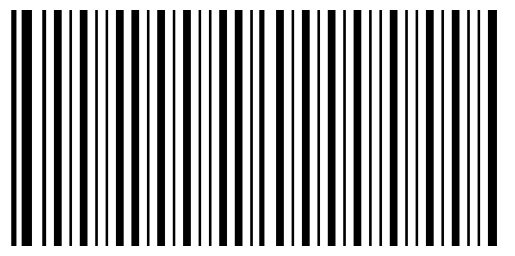

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files
from itertools import groupby
import math
from PIL import Image

# Function to detect if picture has salt and pepper noise
def has_salt_and_pepper_noise(image: np.ndarray, threshold: float = 0.2) -> bool:
    """
    Check if the image has salt-and-pepper noise in the background based on pixel variation.

    Parameters:
        image (np.ndarray): The input image (grayscale or color).
        threshold (float): The proportion of noisy pixels to total pixels to classify
                           the image as noisy. Default is 0.01 (1%).

    Returns:
        bool: True if salt-and-pepper noise is detected, False otherwise.
    """
    # Convert to grayscale if the image is in color


    # Define a kernel to compute differences with neighbors
    kernel = np.array([[1, 1, 1],
                       [1, -8, 1],
                       [1, 1, 1]])

    # Convolve the image with the kernel to detect noise
    filtered = cv2.filter2D(image, -1, kernel)

    # Identify potential noise pixels: high absolute differences
    noise_mask = np.abs(filtered) > 50  # Adjust the threshold as needed

    # Compute the proportion of noisy pixels
    noisy_pixel_ratio = np.sum(noise_mask) / image.size
    print(noisy_pixel_ratio)

    # Check if the proportion exceeds the threshold
    return noisy_pixel_ratio > threshold


# Function to detect obstruction in the image
def detect_obstruction(image):
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    obstruction_mask = thresholded_img == 255
    if np.any(obstruction_mask):
        print("Obstruction detected (dynamic thresholding).")
        return True

    print("No obstruction detected.")
    return False
#-------------------------------------------------------------------------------

# Function to fix obstruction
def fix_obstruction(image, kernel_size=(150, 1)):
    print("Fixing obstruction...")
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones(kernel_size, np.uint8)
    # to fix the finger problem i need to open first the thersholded image then close it
    closed_image = cv2.morphologyEx(thresholded_img, cv2.MORPH_CLOSE, kernel)
    return closed_image
#-------------------------------------------------------------------------------

# Function to crop the image to the barcode region
def cropped_image(image):
  # Use Canny edge detection
    edges = cv2.Canny(image, 50, 150)
    # Detect vertical lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=150, maxLineGap=10)
    min_x, max_x, min_y, max_y = float('inf'), -float('inf'), float('inf'), -float('inf')

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Vertical lines: x1 == x2 or nearly vertical
            if abs(x1 - x2) < 10:
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)
            elif abs(y1 - y2) < 10:  # Horizontal lines
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)

    if min_x != float('inf') and max_x != -float('inf') and min_y != float('inf') and max_y != -float('inf'):
        return image[min_y:max_y, min_x:max_x]


def check_if_needs_opening(image):
    # Apply thresholding to binarize the image
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Define a kernel for morphological operations (5x5)
    kernel = np.ones((5, 5), np.uint8)

    # Count small components before opening
    before_opening_count = count_small_components(binary_image)

    # Apply opening operation
    opened_image_2 = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Count small components after opening
    after_opening_count = count_small_components(opened_image_2)

    # Check if opening operation was effective
    if before_opening_count > after_opening_count:
        return True
    else:
        return False

# Function to count small components (e.g., using connected components)
def count_small_components(binary_img, area_threshold=20):
    # Find connected components
    num_labels, labels = cv2.connectedComponents(binary_img)
    small_components = 0

    for label in range(1, num_labels):  # Ignore the background (label 0)
        # Find the area of each component
        component_area = np.sum(labels == label)
        if component_area < area_threshold:  # Small component
            small_components += 1

    return small_components

def apply_closing(image, kernel_size=(5, 5)):

    # Create a structuring element (kernel) for erosion and dilation
    kernel = np.ones(kernel_size, np.uint8)

    # Apply the opening operation: erosion followed by dilation
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    return closed_image

def apply_opening(image, kernel_size=(5, 5)):
    # Create a structuring element (kernel) for erosion and dilation
    kernel = np.ones(kernel_size, np.uint8)

    # Apply the opening operation: erosion followed by dilation
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    return opened_image
# Function to calculate the angle from the slope
def calculate_angle_from_slope(slope):
    if slope == float('inf'):  # Vertical line
        return 90  # 90 degrees for vertical lines
    # Calculate angle in radians and convert to degrees
    angle_rad = math.atan(slope)
    angle_deg = math.degrees(angle_rad)
    return angle_deg



# Function to calculate the slope of a line
def calculate_slope(x1, y1, x2, y2):
    if x2 - x1 != 0:
        return (y2 - y1) / (x2 - x1)  # Slope formula
    else:
        return float('inf')  # Infinite slope (vertical line)

def detect_sinusoidal_noise(image, threshold_factor=5):
    # Perform FFT
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency component to center

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(fshift)

    # Visualize the magnitude spectrum
    # Compute the magnitude spectrum and take log for better visualization
    log_magnitude = np.log(magnitude_spectrum + 1)

    # Compute mean and standard deviation of the magnitude spectrum
    mean_val = np.mean(log_magnitude)
    std_dev = np.std(log_magnitude)

    # Set a threshold for significant peaks (noise detection)
    threshold = mean_val + threshold_factor * std_dev

    # Count how many points exceed the threshold (this indicates sinusoidal noise)
    # Create a mask to identify peaks
    mask = log_magnitude > threshold

    # Find peaks that are isolated (using min_peak_distance for separation)
    # Peaks should be distinct from their neighbors
    peaks = []
    rows, cols = mask.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if mask[i, j]:
                # Check if this is a peak compared to its neighbors
                neighbors = log_magnitude[i-1:i+2, j-1:j+2]
                if log_magnitude[i, j] == np.max(neighbors):  # Local maximum
                    peaks.append((i, j))

    # If the number of peaks is significant, we assume sinusoidal noise
    print(f"Detected {len(peaks)} peaks above the threshold.")

    # If there are peaks, we assume sinusoidal noise is present
    # Optionally, you can refine further using peak distance to reduce false positives
    return len(peaks) > 50  # Adjust this threshold to your needs

def remove_sinusoidal(image):
    # Perform FFT
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency component to center

    # Visualize the magnitude spectrum before filtering
    magnitude_spectrum = np.log(np.abs(fshift) + 1)

    # Create a mask to filter out sinusoidal noise
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the image

    # You can modify this mask to cover specific noise frequencies
    mask = np.ones((rows, cols), np.uint8)
    r = 10  # radius of the notch filter
    center = [crow, ccol]

    # Apply a circular notch filter (you can change the area of the filter based on the noise)
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2) < r:
                mask[i, j] = 0

    # Apply the mask to the frequency domain
    fshift = fshift * mask

    # Inverse FFT to get the image back
    f_ishift = np.fft.ifftshift(fshift)
    image_back = np.fft.ifft2(f_ishift)
    image_back = np.uint8(np.clip(image_back, 0, 255))

    angle = check_angle(image_back)

    if angle != 90:
        image_np = Image.fromarray(image_back, 'L')
        rotated_image = image_np.rotate(angle - 90, fillcolor='white')
    else:
        rotated_image = Image.fromarray(image_back, 'L')

    np_image_rotated = np.array(rotated_image)
    _, binary_image_1 = cv2.threshold(np_image_rotated, 0, 255, cv2.THRESH_BINARY)
    np_binary_image_1 = np.array(binary_image_1)
    image_cropped = cropped_image(np_binary_image_1)
    kernel_size = (150, 1)
    if check_if_needs_opening(image_cropped):
        opened_image = apply_opening(image_cropped, kernel_size)
        closed_image = apply_closing(opened_image, kernel_size)
    else:
        return image_cropped

    return closed_image

def check_angle(image):
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # plt.imshow(img_gray, cmap='gray')
    # Apply Canny edge detection
    edges = cv2.Canny(image, 50, 150)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=150, maxLineGap=10)
    slope = 0
    # Loop through all detected lines and calculate slopes
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            slope = calculate_slope(x1, y1, x2, y2)
            break
    # Calculate angle from the slope
    angle = calculate_angle_from_slope(slope)
    return angle

def adjust_barcode_angle(image):
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            slope = calculate_slope(x1, y1, x2, y2)
            angle = calculate_angle_from_slope(slope)
            break
            return angle

def barcode_completion(image):
   # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91, 25)

    # Erosion with a 5x1 kernel to remove noise and enhance barcode structure
    kernel = np.ones((5, 1), np.uint8)
    cv2.erode(image, kernel, iterations=2)  # Reduced number of iterations

    # Reduce the image horizontally (average over columns)
    reduced_h = cv2.reduce(image, 0, cv2.REDUCE_AVG)

    # Create a copy of the original image for drawing the barcode structure graph
    reduced_h_graph = image.copy()

    # Add a border to the bottom of the image to create space for the projection graph
    reduced_h_graph = cv2.copyMakeBorder(reduced_h_graph, 0, 100, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # Draw the barcode structure graph based on the projection
    for i in range(image.shape[1]):  # Iterate over all columns
        if reduced_h[0, i] > 100:  # Adjust the threshold value as needed
            cv2.line(reduced_h_graph, (i, reduced_h_graph.shape[0] - 101), (i, reduced_h_graph.shape[0]), (255, 255, 255), 1)
    return reduced_h_graph


def crop_bottom_quarter(image):
    """
    Crop the bottom quarter of the image.
    """
    height = image.shape[0]
    bottom_quarter = image[height // 4 * 3:, :]
    return bottom_quarter


def process_image(img):

    # Convert to Grayscale
    plt.imshow(img, cmap='gray')

    # Step 2: Detect the problem in the image

    is_obstructed = detect_obstruction(img)

    # Step 3: Fix detected problems
    if is_obstructed:
        print("Problem Detected: Obstruction")
        fixed_img = fix_obstruction(img)
    else:
        print("No Major Problem Detected, Proceeding with Original Image")
        fixed_img = img

    # Step 4: Crop the image to focus on the barcode region
    cropped_barcode = cropped_image(fixed_img)

    # Step 5: Display Results
    return cropped_barcode

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle - 90, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), borderValue=(255, 255, 255))
    return rotated_image

# Example usage:
image_path = '/content/SaltPepper.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Input must be a valid image array.")
    # Check if the image is already grayscale
if len(image.shape) == 3:  # Multi-channel image (e.g., BGR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    gray = image  # Already grayscale

if has_salt_and_pepper_noise(gray):
    def Remove_Salt_Pepper(img_gray):
        # Step 1: Median Filter to remove salt-and-pepper noise
        median_filtered = cv2.medianBlur(img_gray, 3)  # Kernel size 3, adjust as needed

        # Step 2: Bilateral Filter for additional smoothing while preserving edges
        denoised_img = cv2.bilateralFilter(median_filtered, 5, 150, 150)

        # Step 3: Adaptive Threshold for binarization
        thresh = cv2.adaptiveThreshold(denoised_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 71, 25)
        return thresh
    cleaned_image = Remove_Salt_Pepper(gray)
    cleaned_cropped = cropped_image(cleaned_image)
    barcode_result = barcode_completion(cleaned_cropped)
    bottom_quarter = crop_bottom_quarter(barcode_result)
    completed_barcode = barcode_completion(bottom_quarter)
    plt.imshow(completed_barcode, cmap='gray')
    plt.axis('off')
elif detect_sinusoidal_noise(image):
    print("Sinusoidal noise detected. Removing...")
    cleaned_image = remove_sinusoidal(image)

    # Display original and cleaned image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Image After Noise Removal")
    plt.imshow(cleaned_image, cmap="gray")
    plt.axis('off')
    plt.show()
elif (check_angle(image) != 90 and check_angle(image) != 0):
    print("No sinusoidal noise detected. No need to remove.")
    print(check_angle(image))

    # Convert numpy array to PIL image
    pil_image = Image.fromarray(image)

    # Rotate the image using PIL
    angle = check_angle(image) - 90
    rotated_image = pil_image.rotate(angle, fillcolor='white')

    # Convert back to numpy array
    rotated_image = np.array(rotated_image)

    # Apply thresholding if needed
    _, binary = cv2.threshold(rotated_image, 127, 255, cv2.THRESH_BINARY)

    # You might need to define cropping logic here:
    cropped_image = cropped_image(rotated_image)  # Assuming cropped_image is a function you defined

    if check_if_needs_opening(cropped_image):
        kernel_size = (150, 1)
        opened_image = apply_opening(cropped_image, kernel_size)
        closed_image = apply_closing(opened_image, kernel_size)
        plt.imshow(closed_image, cmap="gray")
        plt.axis('off')
        plt.show()
    else:
        print("The image won't change.")
        plt.imshow(cropped_image, cmap="gray")
        plt.axis('off')
        plt.show()

else:
    processed_image = process_image(image)
    plt.imshow(processed_image, cmap="gray")
    plt.axis('off')
    plt.show()


In [ ]:
import cv2
import numpy as np

image = cv2.imread('testcases/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)

def has_salt_and_pepper_noise(image: np.ndarray, threshold: float = 0.2) -> bool:
    """
    Check if the image has salt-and-pepper noise in the background based on pixel variation.

    Parameters:
        image (np.ndarray): The input image (grayscale or color).
        threshold (float): The proportion of noisy pixels to total pixels to classify
                           the image as noisy. Default is 0.01 (1%).

    Returns:
        bool: True if salt-and-pepper noise is detected, False otherwise.
    """
    # Convert to grayscale if the image is in color


    # Define a kernel to compute differences with neighbors
    kernel = np.array([[1, 1, 1],
                       [1, -8, 1],
                       [1, 1, 1]])

    # Convolve the image with the kernel to detect noise
    filtered = cv2.filter2D(image, -1, kernel)

    # Identify potential noise pixels: high absolute differences
    noise_mask = np.abs(filtered) > 50  # Adjust the threshold as needed

    # Compute the proportion of noisy pixels
    noisy_pixel_ratio = np.sum(noise_mask) / image.size
    print(noisy_pixel_ratio)

    # Check if the proportion exceeds the threshold
    return noisy_pixel_ratio > threshold
